In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import time
import pickle
import os
from math import log
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, ParameterGrid,StratifiedKFold, cross_val_score

from sklearn import metrics 
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score, brier_score_loss, f1_score, log_loss,auc,roc_curve,auc

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import PCA
#from sklearn.utils.fixes import signature

from datetime import datetime

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Techprocess Alternate")

In [3]:
##read datasets
df=pd.read_csv(os.getcwd()+r"\Data Files\new exi scorecard evaluation.csv")

In [4]:
df.head()

,SKP_CREDIT_CASE,TIME_DECISION_DATE,RISK_AGRF180,RISK_FPD30,RISK_FSPD30,RISK_FSTPD30,RISK_FSTQPD30,RISK_FSTQPD60,PRODUCT_GROUP,NTC_FLAG,...,DATE_5,REASON_5,CODE_5,AMT_5,DATE_6,REASON_6,CODE_6,AMT_6,GENERALMODELLG,GENERALMODELLOGREG
0,321312254,24-09-20,0,0,0,0,0,0,CD,Others,...,02-08-19,0,Debited,1329.0,02-05-19,0,Debited,1329.0,0.066354,0.063158
1,321312154,24-09-20,0,0,0,0,0,0,CD,Others,...,05-09-17,0,Debited,1067.0,05-08-17,0,Debited,1067.0,0.015561,0.017611
2,321312151,24-09-20,0,0,0,0,0,0,CD,Others,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.031091,0.020464
3,321312150,24-09-20,0,0,0,0,0,0,CD,Others,...,12-05-17,0,Debited,1732.0,12-04-17,0,Debited,1732.0,0.048232,0.036273
4,321311952,24-09-20,0,0,0,0,0,0,CD,Others,...,08-04-19,XNA,Debited,1653.0,08-03-19,XNA,Debited,1653.0,0.069972,0.052575


In [9]:
coding_dict={'Balance Insufficient':'WILLFULL DEFAULTS',
'CLEARED BAL/FUNDS/DP NOT AVAILABLE.CARE! ACCT WILL BE OVERDRAWN                               000000':'WILLFULL DEFAULTS',
'DP NOT AVAILABLE. ACCT CANNOT BE OVERDRAWN':'WILLFULL DEFAULTS',
'CLEARED BAL/FUNDS/DP NOT AVAILABLE.CARE! ACCT WILL BE OVERDRAWN':'WILLFULL DEFAULTS',
'ACCT HAS HOLD. INSUFFICIENT FREE BAL FOR TXN':'WILLFULL DEFAULTS',
'INSUFFICIENT FUNDS':'WILLFULL DEFAULTS',
'CODE_DDS_ERROR_REASON':'PROCESS ISSUE',
'A/C Blocked or Frozen':'PROCESS ISSUE',
'Miscellaneous-Dormant A/c(No t':'PROCESS ISSUE',
'Miscellaneous-Dormant A/c(No':'PROCESS ISSUE',
'UMRN QUOTED IN FILE IS NOT VALID':'PROCESS ISSUE',
'NON-Home debit txn on Inoperative/Unclaimed a/c NOT allowed':'PROCESS ISSUE',
'Invalid UMRN or inactive man':'PROCESS ISSUE',
'ACCOUNT CLOSED':'PROCESS ISSUE',
'PERIDICITY FOR MANDATE RECORD IS OVER':'PROCESS ISSUE',
'Settlement Date before manda':'PROCESS ISSUE',
'Invalid UMRN or inactive mandate':'PROCESS ISSUE',
'MANDATE REJECT: No Signature in CBS':'PROCESS ISSUE',
'Mismatch in mandate debtor b':'PROCESS ISSUE',
'MANDATE RECORD IS NOT AUTHORISED':'PROCESS ISSUE',
'Invalid Bank Identifier - Rece':'PROCESS ISSUE',
'Miscellaneous-Network Failure(':'PROCESS ISSUE',
'Mandate Not Received/UMRN Do':'PROCESS ISSUE',
'Invalid Bank Identifier - Receiving participant blocked/disabled':'PROCESS ISSUE',
'Mismatch in Mandate Debtor A':'PROCESS ISSUE',
'Mandate Not Received/UMRN Does not EXist':'PROCESS ISSUE',
'Miscellaneous-Dormant A/c(No transaction for last six months':'PROCESS ISSUE',
'0':'DEBITED',
'XNA':'DEBITED',
            }

In [10]:
def encoding(x):
    try:
        return(coding_dict[x])
    except:
        return ("Others")

In [11]:
df["REASON_1_ENCODED"]= df["REASON_1"].apply(encoding)
df["REASON_2_ENCODED"]= df["REASON_2"].apply(encoding)
df["REASON_3_ENCODED"]= df["REASON_3"].apply(encoding)
df["REASON_4_ENCODED"]= df["REASON_4"].apply(encoding)
df["REASON_5_ENCODED"]= df["REASON_5"].apply(encoding)
df["REASON_6_ENCODED"]= df["REASON_6"].apply(encoding)


In [12]:
df.columns

Index(['SKP_CREDIT_CASE', 'TIME_DECISION_DATE', 'RISK_AGRF180', 'RISK_FPD30',
       'RISK_FSPD30', 'RISK_FSTPD30', 'RISK_FSTQPD30', 'RISK_FSTQPD60',
       'PRODUCT_GROUP', 'NTC_FLAG', 'CLIENT_EXI_3M', 'RISK_SCORE',
       'AMT_DIRECT_DEBIT_STATEMENT', 'DATE_1', 'REASON_1', 'CODE_1', 'AMT_1',
       'DATE_2', 'REASON_2', 'CODE_2', 'AMT_2', 'DATE_3', 'REASON_3', 'CODE_3',
       'AMT_3', 'DATE_4', 'REASON_4', 'CODE_4', 'AMT_4', 'DATE_5', 'REASON_5',
       'CODE_5', 'AMT_5', 'DATE_6', 'REASON_6', 'CODE_6', 'AMT_6',
       'GENERALMODELLG', 'GENERALMODELLOGREG', 'REASON_1_ENCODED',
       'REASON_2_ENCODED', 'REASON_3_ENCODED', 'REASON_4_ENCODED',
       'REASON_5_ENCODED', 'REASON_6_ENCODED'],
      dtype='object')

<AxesSubplot:ylabel='Frequency'>

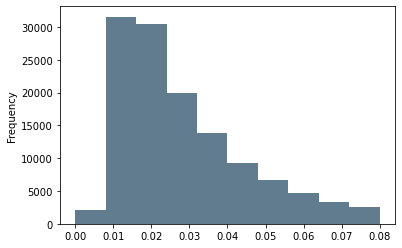

In [16]:
# Check distribution of scores
pd.Series(df['GENERALMODELLOGREG']).plot.hist(bins=10, range=(0,0.08) ,color='#607c8e')

In [24]:
hcc_score='GENERALMODELLOGREG'

# HCC score Gini         
metric_auc_hcc = metrics.roc_auc_score(df['RISK_FSTQPD30'], df[hcc_score])
gini_hcc_only = 2 * metric_auc_hcc - 1
print("HCIN SCORE GINI:" ,gini_hcc_only)

HCIN SCORE GINI: 0.37893832505125746


In [25]:
df["TIME_DECISION_DATE"] = pd.to_datetime(df["TIME_DECISION_DATE"],format ='%d-%m-%y')

df["MONTH"]= df["TIME_DECISION_DATE"].dt.strftime("%y-%m")

In [26]:
df_summ = df.groupby("MONTH").aggregate(["count","sum"])["RISK_FSTQPD30"]
df_summ["bad_rate"] = df_summ["sum"]/df_summ["count"]

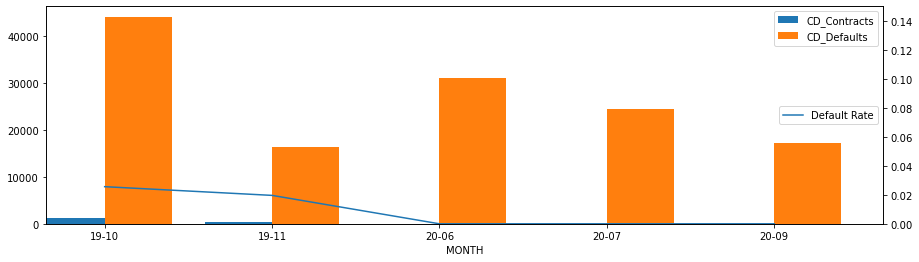

In [27]:
df_summ[['sum','count']].plot(kind='bar', width = 0.8, figsize=(15,4))
df_summ['bad_rate'].plot(secondary_y=True)

ax = plt.gca()
plt.xlim([-0.35, len(df_summ['sum'])-0.35])
ax.set_xticklabels(df_summ.index)
plt.ylim
fig = ax.get_figure()
ax = fig.get_axes()
ax[1].set_ylim(0,0.15)
ax[0].legend(['CD_Contracts','CD_Defaults'])
ax[1].legend(["Default Rate"], loc = "center right")


plt.show()


In [28]:
#MOM Gini Risk Score
for x in df["MONTH"].unique():
    try:   
        metric_auc_hcc = metrics.roc_auc_score(df[df["MONTH"]==x]['RISK_FSTQPD30'], df[df["MONTH"]==x][hcc_score])
        gini_hcc_only = 2 * metric_auc_hcc - 1
        print(x ,gini_hcc_only)  
    except:
        print("ERROR")

ERROR
ERROR
ERROR
19-11 0.4684763133680361
19-10 0.39109193151270394


In [29]:
df["DATE_1"] = pd.to_datetime(df["DATE_1"],format ='%d-%m-%y')
df["DATE_2"] = pd.to_datetime(df["DATE_2"],format ='%d-%m-%y')
df["DATE_3"] = pd.to_datetime(df["DATE_3"],format ='%d-%m-%y')
df["DATE_4"] = pd.to_datetime(df["DATE_4"],format ='%d-%m-%y')
df["DATE_5"] = pd.to_datetime(df["DATE_5"],format ='%d-%m-%y')
df["DATE_6"] = pd.to_datetime(df["DATE_6"],format ='%d-%m-%y')

In [30]:
#Tenure Variables 
df["TENURE1"] = (df["TIME_DECISION_DATE"]-df["DATE_1"]).dt.days
df["TENURE2"] = (df["TIME_DECISION_DATE"]-df["DATE_2"]).dt.days
df["TENURE3"] = (df["TIME_DECISION_DATE"]-df["DATE_3"]).dt.days
df["TENURE4"] = (df["TIME_DECISION_DATE"]-df["DATE_4"]).dt.days
df["TENURE5"] = (df["TIME_DECISION_DATE"]-df["DATE_5"]).dt.days
df["TENURE6"] = (df["TIME_DECISION_DATE"]-df["DATE_6"]).dt.days




In [31]:
#One Hot Encoding
df_encoded = df
for x in ["CODE_1","CODE_2","CODE_3","CODE_4","CODE_5","CODE_6",'REASON_1_ENCODED', 'REASON_2_ENCODED',
       'REASON_3_ENCODED', 'REASON_4_ENCODED', 'REASON_5_ENCODED',
       'REASON_6_ENCODED']:
    
    dummy = pd.get_dummies(df_encoded[x])
    dummy.columns = [y+"_"+x for y in dummy.columns]
    df_encoded = pd.concat([df_encoded, dummy], axis=1)

In [32]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SKP_CREDIT_CASE,133004.0,2.976049e+08,1.606802e+07,2.784562e+08,2.801353e+08,3.073558e+08,3.109461e+08,3.213123e+08
RISK_AGRF180,133004.0,1.965505e-01,3.973910e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
RISK_FPD30,133004.0,8.714024e-03,9.294167e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
RISK_FSPD30,133004.0,1.282668e-02,1.125267e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
RISK_FSTPD30,133004.0,1.027037e-02,1.008214e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
RISK_FSTQPD30,133004.0,1.090193e-02,1.038420e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
RISK_FSTQPD60,133004.0,8.345614e-03,9.097267e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
RISK_SCORE,132799.0,2.437743e-02,3.022449e-02,1.331020e-03,1.008445e-02,1.600425e-02,2.669409e-02,5.062065e-01
AMT_DIRECT_DEBIT_STATEMENT,133004.0,1.940632e+03,1.081518e+03,0.000000e+00,1.395000e+03,1.694000e+03,2.090000e+03,1.757200e+04
AMT_1,132274.0,1.831414e+03,1.044577e+03,0.000000e+00,1.330000e+03,1.613000e+03,1.981000e+03,1.757200e+04


In [33]:
df = df_encoded

In [40]:
x_column = ['TENURE3',
  'TENURE4',
  'TENURE5',
  'TENURE6',
  'Undebited_CODE_1',
  'Undebited_CODE_3',
  'Undebited_CODE_6',
  'WILLFULL DEFAULTS_REASON_5_ENCODED',
  'Undebited_CODE_2',
  'Undebited_CODE_4',
  'WILLFULL DEFAULTS_REASON_4_ENCODED']
y_column = 'RISK_FSTQPD30'

In [52]:
bst = pickle.load(open(os.getcwd()+r"\model_cd_exi.pkl", "rb"))
df["XGB_SCORE"] = bst.predict_proba(df[x_column], ntree_limit=bst.best_ntree_limit)[:, 1]

In [53]:
df_test = df[(df["TIME_DECISION_DATE"]>= pd.datetime(2019,11,1))&(df["TIME_DECISION_DATE"]< pd.datetime(2019,12,1))]
df_train = df[df["TIME_DECISION_DATE"]< pd.datetime(2019,11,1)]


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


In [55]:
## Pillar  approach to combine score
hcc_score = 'GENERALMODELLOGREG'
X_pillar_train = pd.DataFrame()
X_pillar_test = pd.DataFrame()

X_pillar_train[hcc_score]=df_train['RISK_SCORE']; 
X_pillar_test[hcc_score]=df_test['RISK_SCORE']

X_pillar_train["XGB_SCORE"] =  df_train['XGB_SCORE']
X_pillar_test["XGB_SCORE"]  =  df_test['XGB_SCORE']

X_pillar_train["FSTQ"] = df_train['RISK_FSTQPD30']
X_pillar_test["FSTQ"] = df_test['RISK_FSTQPD30']

X_train_log = X_pillar_train.loc[pd.notnull(X_pillar_train[hcc_score]),[hcc_score,'XGB_SCORE']]
y_train_log = X_pillar_train.loc[pd.notnull(X_pillar_train[hcc_score]),['FSTQ']]

X_test_log = X_pillar_test.loc[pd.notnull(X_pillar_test[hcc_score]),[hcc_score,'XGB_SCORE']]
y_test_log = X_pillar_test.loc[pd.notnull(X_pillar_test[hcc_score]),['FSTQ']]

X_train_log = np.log((X_train_log + 1e-10).divide(1 - (X_train_log + 1e-10)))
X_test_log = np.log((X_test_log + 1e-10).divide(1 - (X_test_log + 1e-10)))




In [63]:
df["HCC_SCORE_LOG"]= np.log((df[hcc_score] + 1e-10).divide(1 - (df[hcc_score] + 1e-10)))
df["XGB_SCORE_LOG"]= np.log((df["XGB_SCORE"] + 1e-10).divide(1 - (df["XGB_SCORE"] + 1e-10)))


In [59]:
logreg = LogisticRegression(C=11, n_jobs=-1)

# cross validation gini
kfolds = StratifiedKFold(10, random_state=1)
auc_cv = cross_val_score(logreg, X_train_log, np.ravel(y_train_log), scoring='roc_auc',
                         cv=kfolds.split(X_test_log, np.ravel(y_test_log)), n_jobs=-1)
gini_cv = (2 * np.array(auc_cv) - 1).mean()

logreg.fit(X_train_log, np.ravel(y_train_log))
log_coef_tbl = pd.DataFrame({'predictor': ['intercept'] + X_train_log.columns.tolist(),
                             'coefficient': list(logreg.intercept_) + list(logreg.coef_[0])})
log_coef_tbl = log_coef_tbl[['predictor', 'coefficient']]

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


In [60]:
log_coef_tbl

,predictor,coefficient
0,intercept,-2.264672
1,GENERALMODELLOGREG,0.422051
2,XGB_SCORE,1.526889


In [61]:
## Model performance
ypred_train_pillar = logreg.predict_proba(X_train_log)[:, 1]
metric_auc_train_log = metrics.roc_auc_score(np.ravel(y_train_log), ypred_train_pillar)
gini_train_pillar = 2 * metric_auc_train_log - 1
ypred_test_pillar = logreg.predict_proba(X_test_log)[:, 1]
metric_auc_test_log = metrics.roc_auc_score(np.ravel(y_test_log), ypred_test_pillar)
gini_test_pillar = 2 * metric_auc_test_log - 1

print("GINI TRAIN:",gini_train_pillar )
print("GINI TEST:",gini_test_pillar )
print("GINI CV:",gini_cv)

GINI TRAIN: 0.36938650229515835
GINI TEST: 0.4277199892758825
GINI CV: 0.3800553048259591


In [64]:
df["COMBINED_SCORE"] = logreg.predict_proba(df[['HCC_SCORE_LOG', 'XGB_SCORE_LOG']])[:, 1]

In [67]:
print("COMBINED:",2*metrics.roc_auc_score(df["RISK_FSTQPD30"], df["COMBINED_SCORE"])-1)
print("RISK:",2*metrics.roc_auc_score(df["RISK_FSTQPD30"], df[hcc_score])-1)
print("XGB:",2*metrics.roc_auc_score(df["RISK_FSTQPD30"], df["XGB_SCORE"])-1)


COMBINED: 0.4239137147299681
RISK: 0.37893832505125746
XGB: 0.3261401821095624


In [68]:
df.to_pickle(os.getcwd()+"\scored_cd_exi_with_new_gm.pkl")

In [69]:
df.to_csv(os.getcwd()+"\scored_cd_exi_with_new_gm.csv")

# Model Evaluation

In [70]:
df = pd.read_pickle(os.getcwd()+"\scored_cd_exi_with_new_gm.pkl")

In [72]:
TIME_DECISION_DATE = "TIME_DECISION_DATE"
FINAL_SCORE = "XGB_SCORE"
RISK_SCORE = "GENERALMODELLOGREG"
COMBINED_SCORE = "COMBINED_SCORE"
TARGET = "RISK_FSTQPD30"
# PREDICTOR_LIST = ['G_RISK_FSTQPD30_SCORE', 'G_RISK_FPD10_SCORE','G_DEFAULT_FLAG_CHANGE_1']
df["MONTH"] = df[TIME_DECISION_DATE].dt.strftime("%y-%m")

# GINI

### Gini Chart

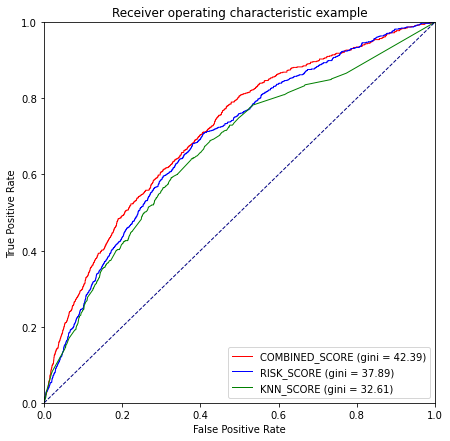

In [73]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

fig = plt.figure(figsize = (7,7))
ax1 = fig.add_subplot(1, 1, 1)

lw = 1
fpr, tpr, thresholds = roc_curve(df[TARGET],df[COMBINED_SCORE])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='red', lw=lw, label='COMBINED_SCORE (gini = %0.2f)' % ((2*roc_auc-1)*100))

fpr, tpr, thresholds = roc_curve(df[TARGET],df[RISK_SCORE])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='blue', lw=lw, label='RISK_SCORE (gini = %0.2f)' % ((2*roc_auc-1)*100))

fpr, tpr, thresholds = roc_curve(df[TARGET],df[FINAL_SCORE])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='green', lw=lw, label='KNN_SCORE (gini = %0.2f)' % ((2*roc_auc-1)*100))

ax1.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### MOM GINI: FSTQPD30

In [74]:
TARGET1 = 'RISK_FSTQPD30'
gini_dic = {}
for x in df["MONTH"].unique():
    try:
        if "MONTH" not in gini_dic:
            gini_dic["MONTH"] = []
        if FINAL_SCORE not in gini_dic: 
            gini_dic[FINAL_SCORE] = []
        if RISK_SCORE not in gini_dic: 
            gini_dic[RISK_SCORE] = []
        if COMBINED_SCORE not in gini_dic: 
            gini_dic[COMBINED_SCORE] = []
        
        gini_dic[FINAL_SCORE].append((2*roc_auc_score(df[df["MONTH"]==x][TARGET1],df[df["MONTH"]==x][FINAL_SCORE])-1)*100)
        gini_dic[RISK_SCORE].append((2*roc_auc_score(df[df["MONTH"]==x][TARGET1],df[df["MONTH"]==x][RISK_SCORE])-1)*100)
        gini_dic[COMBINED_SCORE].append((2*roc_auc_score(df[df["MONTH"]==x][TARGET1],df[df["MONTH"]==x][COMBINED_SCORE])-1)*100)
        gini_dic["MONTH"].append(x)
#         for y in PREDICTOR_LIST:
#             if y not in gini_dic:
#                   gini_dic[y] = []
#             gini_dic[y].append(((2*roc_auc_score(df[df["MONTH"]==x]["RISK_FSTQPD30"],df[df["MONTH"]==x][y])-1)*100))
    except: 
        print("ERROR")

gini_df = pd.DataFrame(gini_dic)
gini_df.sort_values(by = "MONTH",inplace = True)
gini_df.reset_index(inplace = True)


ERROR
ERROR
ERROR


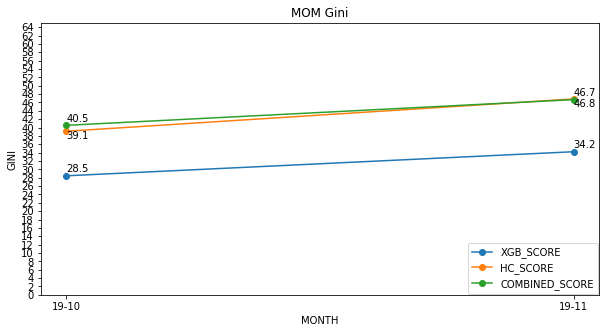

In [77]:
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(gini_df["MONTH"],gini_df["XGB_SCORE"], marker='o', scaley = False, label = "XGB_SCORE")
ax1.plot(gini_df["MONTH"],gini_df[RISK_SCORE], marker='o', scaley = False, label = "HC_SCORE")
ax1.plot(gini_df["MONTH"],gini_df["COMBINED_SCORE"], marker='o', scaley = False, label= "COMBINED_SCORE")

for i, txt in enumerate(gini_df["XGB_SCORE"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["XGB_SCORE"][i]+0.9))
for i, txt in enumerate(gini_df[RISK_SCORE]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df[RISK_SCORE][i]-1.9))
for i, txt in enumerate(gini_df["COMBINED_SCORE"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["COMBINED_SCORE"][i]+0.9))

plt.legend(loc='lower right', borderaxespad=0.1)
plt.ylim(0,65)
plt.ylabel("GINI")
plt.xlabel("MONTH")
plt.yticks(np.arange(0,65,2))
ax1.set_title("MOM Gini")
plt.show()

### MOM GINI: FPD30

In [84]:
TARGET1 = 'RISK_FPD30'
gini_dic = {}
for x in df["MONTH"].unique():
    try:
        if "MONTH" not in gini_dic:
            gini_dic["MONTH"] = []
        if FINAL_SCORE not in gini_dic: 
            gini_dic[FINAL_SCORE] = []
        if RISK_SCORE not in gini_dic: 
            gini_dic[RISK_SCORE] = []
        if COMBINED_SCORE not in gini_dic: 
            gini_dic[COMBINED_SCORE] = []
        
        gini_dic[FINAL_SCORE].append((2*roc_auc_score(df[df["MONTH"]==x][TARGET1],df[df["MONTH"]==x][FINAL_SCORE])-1)*100)
        gini_dic[RISK_SCORE].append((2*roc_auc_score(df[df["MONTH"]==x][TARGET1],df[df["MONTH"]==x][RISK_SCORE])-1)*100)
        gini_dic[COMBINED_SCORE].append((2*roc_auc_score(df[df["MONTH"]==x][TARGET1],df[df["MONTH"]==x][COMBINED_SCORE])-1)*100)
        gini_dic["MONTH"].append(x)
#         for y in PREDICTOR_LIST:
#             if y not in gini_dic:
#                   gini_dic[y] = []
#             gini_dic[y].append(((2*roc_auc_score(df[df["MONTH"]==x]["RISK_FSTQPD30"],df[df["MONTH"]==x][y])-1)*100))
    except: 
        print("ERROR")

gini_df = pd.DataFrame(gini_dic)
gini_df.sort_values(by = "MONTH",inplace = True)
gini_df.reset_index(inplace = True)


ERROR


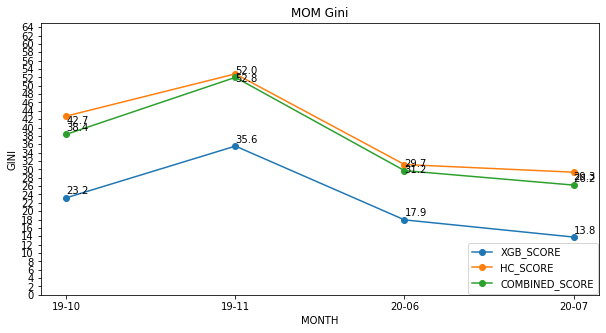

In [85]:
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(gini_df["MONTH"],gini_df["XGB_SCORE"], marker='o', scaley = False, label = "XGB_SCORE")
ax1.plot(gini_df["MONTH"],gini_df[RISK_SCORE], marker='o', scaley = False, label = "HC_SCORE")
ax1.plot(gini_df["MONTH"],gini_df["COMBINED_SCORE"], marker='o', scaley = False, label= "COMBINED_SCORE")

for i, txt in enumerate(gini_df["XGB_SCORE"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["XGB_SCORE"][i]+0.9))
for i, txt in enumerate(gini_df[RISK_SCORE]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df[RISK_SCORE][i]-1.9))
for i, txt in enumerate(gini_df["COMBINED_SCORE"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["COMBINED_SCORE"][i]+0.9))

plt.legend(loc='lower right', borderaxespad=0.1)
plt.ylim(0,65)
plt.ylabel("GINI")
plt.xlabel("MONTH")
plt.yticks(np.arange(0,65,2))
ax1.set_title("MOM Gini")
plt.show()

### MOM GINI: FSPD30

In [86]:
TARGET1 = 'RISK_FSPD30'
gini_dic = {}
for x in df["MONTH"].unique():
    try:
        if "MONTH" not in gini_dic:
            gini_dic["MONTH"] = []
        if FINAL_SCORE not in gini_dic: 
            gini_dic[FINAL_SCORE] = []
        if RISK_SCORE not in gini_dic: 
            gini_dic[RISK_SCORE] = []
        if COMBINED_SCORE not in gini_dic: 
            gini_dic[COMBINED_SCORE] = []
        
        gini_dic[FINAL_SCORE].append((2*roc_auc_score(df[df["MONTH"]==x][TARGET1],df[df["MONTH"]==x][FINAL_SCORE])-1)*100)
        gini_dic[RISK_SCORE].append((2*roc_auc_score(df[df["MONTH"]==x][TARGET1],df[df["MONTH"]==x][RISK_SCORE])-1)*100)
        gini_dic[COMBINED_SCORE].append((2*roc_auc_score(df[df["MONTH"]==x][TARGET1],df[df["MONTH"]==x][COMBINED_SCORE])-1)*100)
        gini_dic["MONTH"].append(x)
#         for y in PREDICTOR_LIST:
#             if y not in gini_dic:
#                   gini_dic[y] = []
#             gini_dic[y].append(((2*roc_auc_score(df[df["MONTH"]==x]["RISK_FSTQPD30"],df[df["MONTH"]==x][y])-1)*100))
    except: 
        print("ERROR")

gini_df = pd.DataFrame(gini_dic)
gini_df.sort_values(by = "MONTH",inplace = True)
gini_df.reset_index(inplace = True)


ERROR


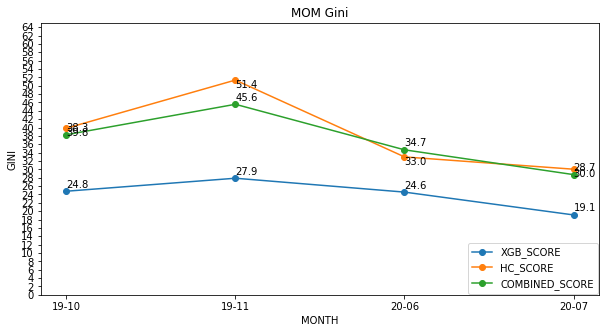

In [87]:
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(gini_df["MONTH"],gini_df["XGB_SCORE"], marker='o', scaley = False, label = "XGB_SCORE")
ax1.plot(gini_df["MONTH"],gini_df[RISK_SCORE], marker='o', scaley = False, label = "HC_SCORE")
ax1.plot(gini_df["MONTH"],gini_df["COMBINED_SCORE"], marker='o', scaley = False, label= "COMBINED_SCORE")

for i, txt in enumerate(gini_df["XGB_SCORE"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["XGB_SCORE"][i]+0.9))
for i, txt in enumerate(gini_df[RISK_SCORE]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df[RISK_SCORE][i]-1.9))
for i, txt in enumerate(gini_df["COMBINED_SCORE"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["COMBINED_SCORE"][i]+0.9))

plt.legend(loc='lower right', borderaxespad=0.1)
plt.ylim(0,65)
plt.ylabel("GINI")
plt.xlabel("MONTH")
plt.yticks(np.arange(0,65,2))
ax1.set_title("MOM Gini")
plt.show()

### MOM GINI: FSTPD30

In [88]:
TARGET1 = 'RISK_FSTPD30'
gini_dic = {}
for x in df["MONTH"].unique():
    try:
        if "MONTH" not in gini_dic:
            gini_dic["MONTH"] = []
        if FINAL_SCORE not in gini_dic: 
            gini_dic[FINAL_SCORE] = []
        if RISK_SCORE not in gini_dic: 
            gini_dic[RISK_SCORE] = []
        if COMBINED_SCORE not in gini_dic: 
            gini_dic[COMBINED_SCORE] = []
        
        gini_dic[FINAL_SCORE].append((2*roc_auc_score(df[df["MONTH"]==x][TARGET1],df[df["MONTH"]==x][FINAL_SCORE])-1)*100)
        gini_dic[RISK_SCORE].append((2*roc_auc_score(df[df["MONTH"]==x][TARGET1],df[df["MONTH"]==x][RISK_SCORE])-1)*100)
        gini_dic[COMBINED_SCORE].append((2*roc_auc_score(df[df["MONTH"]==x][TARGET1],df[df["MONTH"]==x][COMBINED_SCORE])-1)*100)
        gini_dic["MONTH"].append(x)
#         for y in PREDICTOR_LIST:
#             if y not in gini_dic:
#                   gini_dic[y] = []
#             gini_dic[y].append(((2*roc_auc_score(df[df["MONTH"]==x]["RISK_FSTQPD30"],df[df["MONTH"]==x][y])-1)*100))
    except: 
        print("ERROR")

gini_df = pd.DataFrame(gini_dic)
gini_df.sort_values(by = "MONTH",inplace = True)
gini_df.reset_index(inplace = True)


ERROR
ERROR


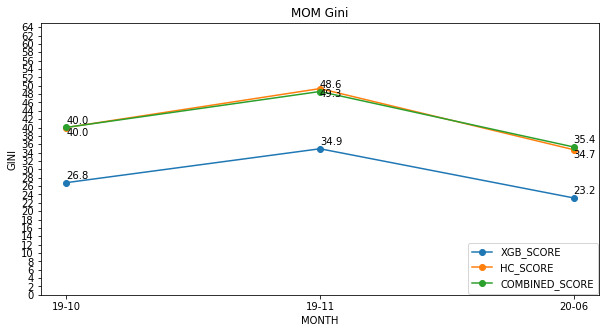

In [89]:
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(gini_df["MONTH"],gini_df["XGB_SCORE"], marker='o', scaley = False, label = "XGB_SCORE")
ax1.plot(gini_df["MONTH"],gini_df[RISK_SCORE], marker='o', scaley = False, label = "HC_SCORE")
ax1.plot(gini_df["MONTH"],gini_df["COMBINED_SCORE"], marker='o', scaley = False, label= "COMBINED_SCORE")

for i, txt in enumerate(gini_df["XGB_SCORE"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["XGB_SCORE"][i]+0.9))
for i, txt in enumerate(gini_df[RISK_SCORE]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df[RISK_SCORE][i]-1.9))
for i, txt in enumerate(gini_df["COMBINED_SCORE"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["COMBINED_SCORE"][i]+0.9))

plt.legend(loc='lower right', borderaxespad=0.1)
plt.ylim(0,65)
plt.ylabel("GINI")
plt.xlabel("MONTH")
plt.yticks(np.arange(0,65,2))
ax1.set_title("MOM Gini")
plt.show()